In [13]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# The ML stuff
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Load the 2024 data
folder_path = "../data/raw/"
file_name = "ice_electric-2024final.xlsx"

# Create dataframe
df = pd.read_excel(folder_path + file_name)

# Rename the columns to be more code-friendly
df.columns = [
    "price_hub", "trade_date", "delivery_start_date", "delivery_end_date",
    "high_price", "low_price", "avg_price", "price_change",
    "daily_volume", "num_trades", "num_counterparties"
]

# Remove non-numerical column price_hub (can be useful, but we keep this exercise simple)
numeric_cols = df.select_dtypes(include='number').columns
numeric = df[numeric_cols]
trade_date = df["trade_date"]
df = pd.concat([trade_date, numeric], axis=1)

# Convert dates to datetime
df["trade_date"] = pd.to_datetime(df["trade_date"])
# Set trade date as index
df.set_index("trade_date", inplace=True)

# Sort by date (nice when plotting)
df.sort_index(inplace=True)

df.head(n=5)

,high_price,low_price,avg_price,price_change,daily_volume,num_trades,num_counterparties
trade_date,,,,,,,
2023-12-27,37.50,34.00,35.27,-0.93,9600,12,11
2023-12-27,38.50,37.50,38.00,3.00,1600,2,3
2023-12-27,30.25,30.00,30.06,-23.94,3200,4,6
2023-12-27,36.00,34.00,35.54,6.45,4800,6,4
2023-12-27,28.10,27.85,27.93,0.88,2400,3,5


In [3]:
# Lagged feature for training
df_ml = df.copy()

# Lagged price features. Lag goes from 1 to 7 days
for lag in range(1, 8): 
    df_ml[f"lag_{lag}"] = df_ml["avg_price"].shift(lag)

# Drop any NaNs induced by lagging
df_ml.dropna(inplace=True)

df_ml.head()

,high_price,low_price,avg_price,price_change,daily_volume,num_trades,num_counterparties,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
trade_date,,,,,,,,,,,,,,
2023-12-28,28.5,28.20,28.27,0.34,8800,11,10,41.08,35.00,27.93,35.54,30.06,38.00,35.27
2023-12-28,23.5,19.00,20.17,-15.37,3600,9,7,28.27,41.08,35.00,27.93,35.54,30.06,38.00
2023-12-28,30.0,29.75,29.81,-0.25,3200,4,7,20.17,28.27,41.08,35.00,27.93,35.54,30.06
2023-12-29,45.0,28.00,34.28,14.11,8000,20,15,29.81,20.17,28.27,41.08,35.00,27.93,35.54
2023-12-29,35.0,33.00,33.65,5.38,12000,14,17,34.28,29.81,20.17,28.27,41.08,35.00,27.93


In [4]:
X = df_ml.drop("avg_price", axis=1)  # Features
y = df_ml["avg_price"]  # Target, labels

# Train test split, 80% train
split_index = int(len(df_ml) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"Train shape {X_train.shape}, Test shape: {X_test.shape}")

Train shape (973, 13), Test shape: (244, 13)


In [5]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predit on data
y_pred = rf_model.predict(X_test)

In [6]:
# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mean_abs_err = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mean_abs_err:.3f}")
print(f"R²: {r2:.3f}")

RMSE: 0.974
MAE: 0.542
R²: 0.997


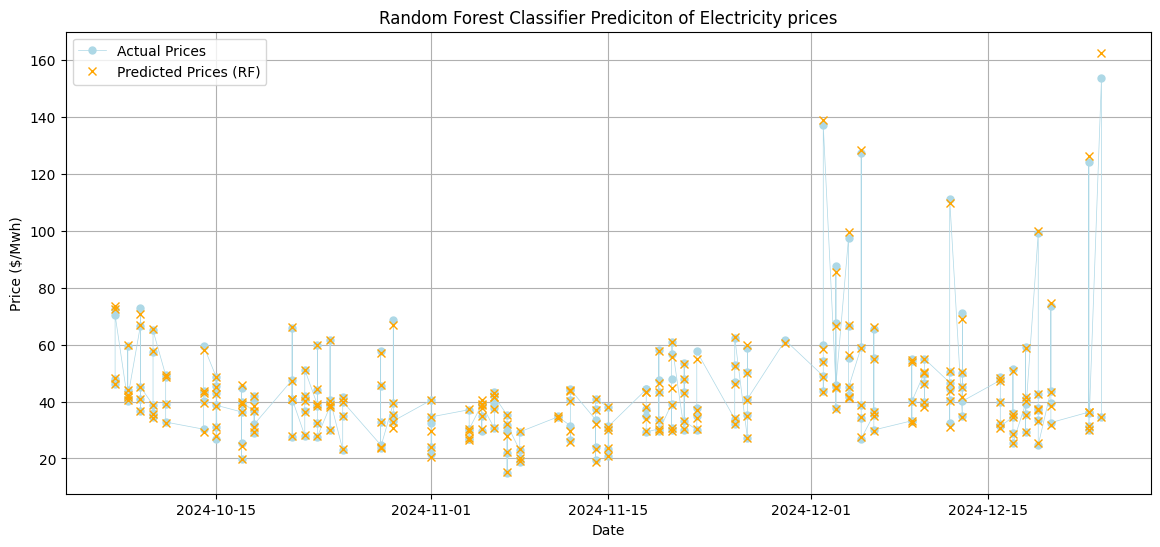

In [49]:
# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(y_test.index, y_test, label="Actual Prices", c="lightblue", marker=".", ls="-", markersize=10, lw=0.5)
ax.plot(y_test.index, y_pred, label="Predicted Prices (RF)", c="orange", marker="x", ls="", markersize=6)
ax.set(xlabel="Date", ylabel="Price ($/Mwh)", title="Random Forest Classifier Prediciton of Electricity prices")
ax.legend()
ax.grid()
plt.show()

### Itereative prediction of the next 14 days
We only have access to the average price lag features, so we retrain the model using only those

In [8]:
# Prepare features and target
X_lags = df_ml[[f"lag_{i}" for i in range(1, 8)]]
y = df_ml["avg_price"]

# Retrain model
split_index = int(len(X_lags) * 0.8)
X_train_lag, X_test_lag = X_lags[:split_index], X_lags[split_index:]
y_train_lag, y_test_lag = y[:split_index], y[split_index:]

rf_model_lag = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_lag.fit(X_train_lag, y_train_lag)

# Perform the forecasting
last_known_lags = X_lags.iloc[-1].copy()
forecasted_prices = []
forecast_horizon = 14

for day in range(forecast_horizon):
    X_pred = pd.DataFrame([last_known_lags])
    next_day_price = rf_model_lag.predict(X_pred)[0]
    forecasted_prices.append(next_day_price)
        
    # Update lag
    # Today's lag_1 is tomorrows lag_2 and so on. Roll all the lag features by 1, then update lag_1
    last_known_lags = last_known_lags.shift(1)
    last_known_lags.iloc[0] = next_day_price

### Plot the forecasting
We plot the historical data and the forecasted data

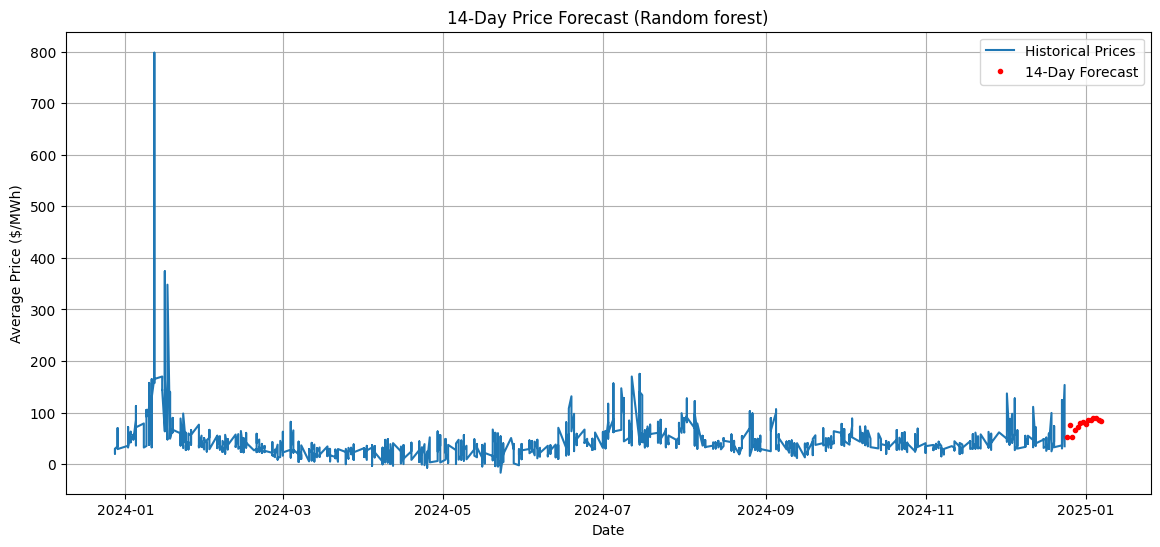

In [9]:
# Create dates for forecasting
last_date = df_ml.index[-1]  # Last data date
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq="D")

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df_ml.index, df_ml["avg_price"], label="Historical Prices")
ax.plot(forecast_dates, forecasted_prices, label="14-Day Forecast", c="red", marker=".", ls="")
ax.set(xlabel="Date", ylabel="Average Price ($/MWh)", title="14-Day Price Forecast (Random forest)")
ax.legend()
ax.grid()
plt.show()


## Neural Network version

Let's see how a Pytorch Neural Network performs!

In [36]:
# This ensures you only use past price data (lags)
X = df_ml[[f'lag_{i}' for i in range(1, 8)]].copy()
y = df_ml["avg_price"].copy()

# Normalize data
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.values.reshape(-1,1))

# Train-test split (maintaining order)
split_idx = int(len(X_scaled) * 0.8)
X_train_scaled, X_test_scaled = X_scaled[:split_idx], X_scaled[split_idx:]
y_train_scaled, y_test_scaled = y_scaled[:split_idx], y_scaled[split_idx:]


In [37]:
# Convert data to PyTorch tensors

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Create datasets containting train data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

In [38]:
# Build the Neural Network

class PricePredictor(nn.Module):
    def __init__(self, input_dim):
        """Create simple Neural network to predict electricity prices

        Args:
            input_dim (int): Number of training features
        """
        super(PricePredictor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        return self.fc(x)
    
# Instantiate model
nn_model = PricePredictor(input_dim=X_train_scaled.shape[1])

In [39]:
# Train the NN model

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    nn_model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = nn_model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} / {num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 10 / 100, Loss: 0.6599
Epoch 20 / 100, Loss: 0.5920
Epoch 30 / 100, Loss: 0.5605
Epoch 40 / 100, Loss: 0.5333
Epoch 50 / 100, Loss: 0.4835
Epoch 60 / 100, Loss: 0.4392
Epoch 70 / 100, Loss: 0.4097
Epoch 80 / 100, Loss: 0.3722
Epoch 90 / 100, Loss: 0.3555
Epoch 100 / 100, Loss: 0.3367


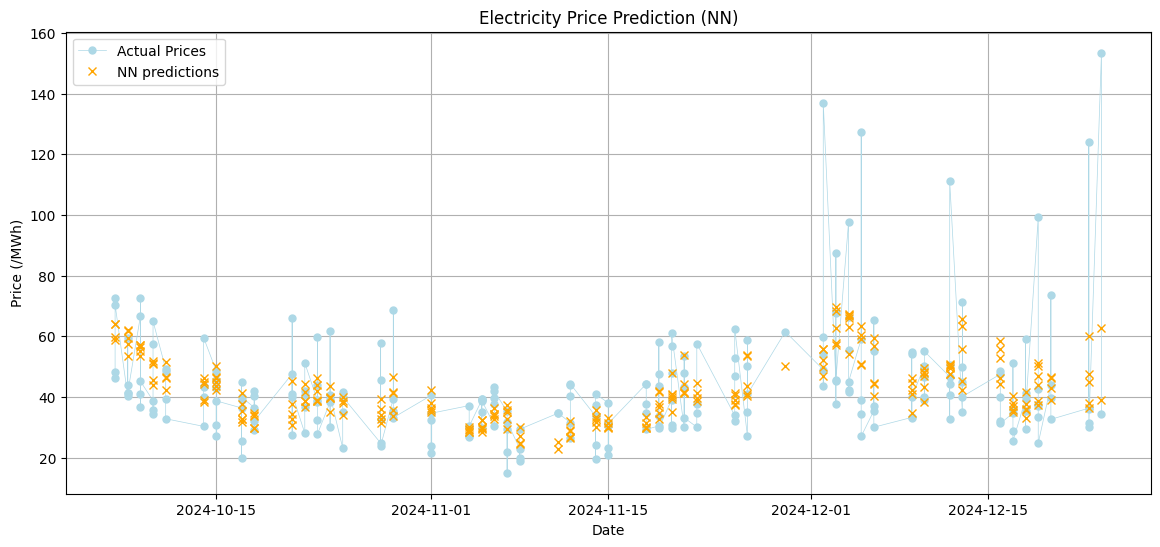

In [51]:
# Evaluate and visualize predictions
nn_model.eval()
# Get the scaled predictions from test data
with torch.no_grad():
    predictions_scaled = nn_model(X_test_tensor).numpy()

# Get the original scale back
predictions_non_scaled = y_scaler.inverse_transform(predictions_scaled)
y_test_original = y_scaler.inverse_transform(y_test_scaled)


# Plot the data and predictions
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df_ml.index[split_index:], y_test_original, label="Actual Prices", c="lightblue", marker=".", ls="-", markersize=10, lw=0.5)
ax.plot(df_ml.index[split_index:], predictions_non_scaled, label="NN predictions", color="orange", marker="x", ls="", markersize=6)
ax.set(xlabel="Date", ylabel="Price (/MWh)", title="Electricity Price Prediction (NN)")
ax.legend()
ax.grid()
plt.show()


In [60]:
# 14 day forecasting
# We pretty much copy the code from before

nn_model.eval()

last_known_lags = X_lags.iloc[-1].copy()
last_known_lags = last_known_lags.to_numpy()
forecasted_prices = []

for day in range(14):  # 2 weeks
    # scale input
    
    input_scaled = X_scaler.transform(last_known_lags.reshape(1, -1))
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32)
    
    # Predict
    with torch.no_grad():
        pred_scaled = nn_model(input_tensor).numpy()
        
    # Inverse scale transform
    next_day_price = y_scaler.inverse_transform(pred_scaled)[0, 0]
    forecasted_prices.append(next_day_price)
    
    # Update lags
    last_known_lags = np.roll(last_known_lags, shift=1)
    last_known_lags[0] = next_day_price    

C:\Users\tobia\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\tobia\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\tobia\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\tobia\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\tobia\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but St

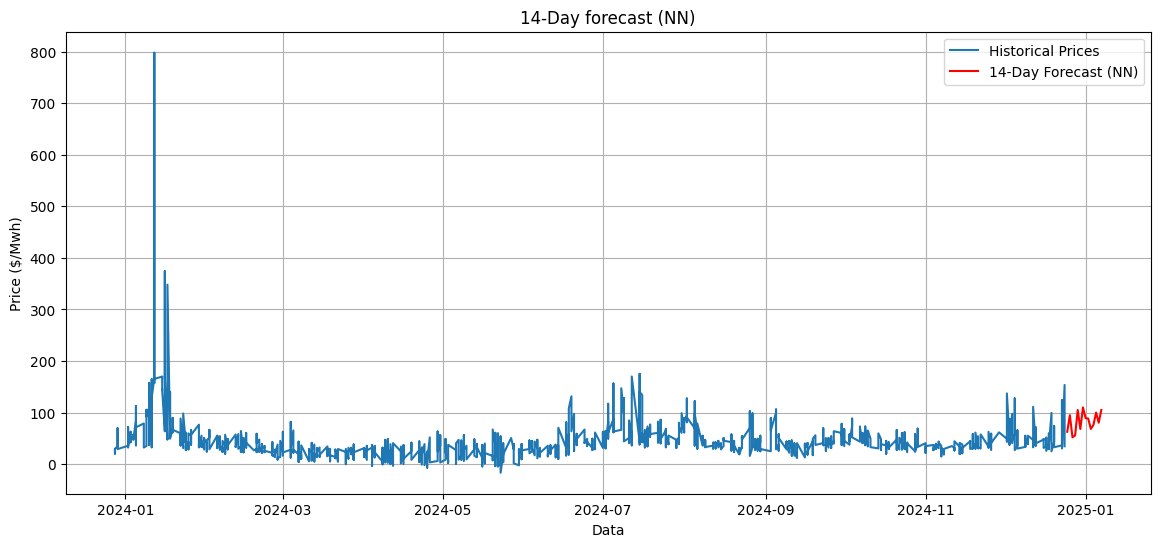

In [64]:
# Visualize forecasted results

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df_ml.index, df_ml["avg_price"], label="Historical Prices")
ax.plot(forecast_dates, forecasted_prices, label="14-Day Forecast (NN)", c="red")
ax.set(xlabel="Data", ylabel="Price ($/Mwh)", title="14-Day forecast (NN)")
ax.legend()
ax.grid()
plt.show()